#### CODE REFACTORED AND BUILT UPON FOUNDATIONAL CODE CREATED BY MEHRDAD ZAREDOOST https://github.com/mehrdadzaa/MoneyCirculation/tree/main

work on large matrices, keep removing submatrices - see dynamics if they stay consistent

# IMPORTS

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import beta, pareto, truncnorm, maxwell, uniform, burr
from scipy.signal import convolve
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.csgraph import connected_components

# PARAMETER CHOICES

### CASES

In [22]:
# #Scenarios: various interact values: 50%, 0.5%, 0.005% (Highly cohesive, Cohesive and Fragmented economies.)
interact = 0.5  # Percentage of interacting agents

a = 2  # Percentage of columns to modify at each timestep
b = 2  # Percentage of elements to modify within columns at each timestep
c = 2  # Maximum change to elements. As each element represents a fraction, c=5 represents a change range of +- (5/100) to F_i,j

### CONSTANTS

In [23]:
n = 5000  # Number of agents

initial_wealth_model = "boltzgibbs"
saving_distribution = "random"
income_distribution = "bose"
lower_bound = 1000
upper_bound = 100000000

top_percent=10
bottom_percent=40

# seed = int(np.random.randint(1,10000))
# f0_seed = int(np.random.randint(1,10000))
# ft_seed = int(np.random.randint(1,10000))
seed=8556
f0_seed=4720
ft_seed=8976

S = 50 # Number of steps to generate Ft matrices
injection_step = 20
injection_percent= 15

tc = interact  # Percentage of non-zero elements to modify in top 10% rows
bc=25  # Percentage of non-zero elements to set to zero in bottom 10% rows

print(f'Seed={seed}; f0_seed={f0_seed}; ft_seed={ft_seed}')

Seed=8556; f0_seed=4720; ft_seed=8976


# FUNCTIONS

## PROBABILITY DISTRIBUTIONS

In [24]:
def generate_boltzmann_gibbs(n):
  # Suggested T Values (Based on 2023 Wealth Data) or T = Average Wealth / Person (M/N)
    # | Economy Type        | Suggested T($) | Notes                                         |
    # |---------------------|----------------|-----------------------------------------------|
    # | Global Economy      | 80,000         | Approx. avg. global wealth per adult          |
    # | USA                 | 500,000        | High wealth concentration in top 10%          |
    # | Europe              | 250,000        | More even wealth distribution than the USA    |
    # | India               | 16,000         | Lower average wealth but rising middle class  |
    # | Developing nations  | 10,000         | Large lower-income populations                |
    #T average wealth per person in a system.

    k = 1  # Boltzmann constant (arbitrary units)
    T = 100000 # for North America
    rate = 1 / (k * T) # Scaling T widens the distribution | Increase T to control overall wealth dispersion

    initial_wealth = np.random.exponential(scale=(1/rate), size=n)


    # Optionally, apply a power-law factor to increase extreme values
    # Combine both to achieve broader wealth distribution
    # Generate Pareto-distributed high values
    pareto_alpha=1.5
    pareto_percentage=10
    num_high_wealth = int((pareto_percentage/100) * n)  # Adjust percentage of high wealth individuals as needed
    pareto_wealth = np.random.pareto(pareto_alpha, size=num_high_wealth)

    # Combine initial wealth with Pareto-distributed wealth
    initial_wealth[:num_high_wealth] += pareto_wealth

    return initial_wealth


def generate_ccm(n):
    """
    Refined CCM Model:
    - More transactions to ensure wealth dispersion.
    - Introduces small noise to avoid identical values.
    - Adjusted scaling for better range adaptation.

    CCM Model (Chakraborti-Chakrabarti Model):
    - Each agent starts with equal wealth.
    - In each transaction, two agents are randomly chosen.
    - A fraction of their combined wealth is exchanged, based on saving propensity.
    - The process is repeated to reach an equilibrium wealth distribution.
    """
    saving_propensity=0.2
    transactions=50000
    wealth = np.ones(n)  # Start with equal uniform wealth

    for _ in range(transactions): #iterations to reach equilibirum
        i, j = np.random.choice(n, 2, replace=False)
        delta_w = (1 - saving_propensity) * (wealth[i] + wealth[j]) / 2
        wealth[i] = saving_propensity * wealth[i] + delta_w
        wealth[j] = saving_propensity * wealth[j] + delta_w

    # Introduce small random noise to break exact equal values
    noise = np.random.uniform(0.001, 0.01, size=n) * np.mean(wealth)
    #noise = np.random.uniform(1e-8, 1e-6, size=n)
    wealth += noise

    return wealth

def generate_pareto(n):
    alpha=2.5
    return np.random.pareto(alpha, size=n)

def generate_lognormal(n):
    sigma,mu=1.5,10
    mu = np.log(mu) - 0.5 * sigma**2  # Convert real-world mean to log-space
    return np.random.lognormal(mu, sigma, size=n)

def generate_gamma(n):
    mean_target = 10000
    shape = 2.0  # Fixed
    scale = mean_target / shape  # Adjust scale to match target mean
    return np.random.gamma(shape, scale, size=n)

def generate_kinetic_exchange(n):
    transactions=10000
    wealth = np.ones(n)
    wealth = np.maximum(wealth, 1e-6)
    for _ in range(transactions):
        i, j = np.random.choice(n, 2, replace=False)
        epsilon = np.random.rand()
        wealth[i], wealth[j] = epsilon * (wealth[i] + wealth[j]), (1 - epsilon) * (wealth[i] + wealth[j])
    return wealth

def generate_weibull(n):
    shape=1.5
    return np.random.weibull(shape, size=n)

def generate_beta(n):
    alpha, beta_param = 0.4, 0.6  # Parameters to control the shape of the distribution
    # can use 2,5 for a more realistic shape
    return beta.rvs(alpha, beta_param, size=n)

def generate_burr(n):
    c = 2.5  # Shape parameter
    d = 1.0  # Scale parameter
    return burr.rvs(c, d, size=n)

def generate_maxwell_boltzmann(n):
    scale = 1.0  # Scale parameter
    return maxwell.rvs(scale, size=n)

def generate_random(n):
    return np.random.rand(n)

def generate_gaussian(n):
    mean = 0  # You can adjust this based on your needs
    std_dev = 1.5  # Adjust standard deviation to match the Weibull scale parameter
    return np.random.normal(loc=mean, scale=std_dev, size=n)


def generate_bose_einstein(n):
    #T = 1.0
    T=100000 #asbefore
    mu = 0.0
    k = 1.0  # Boltzmann constant (normalized)

     # Generate random energy values in a reasonable range
    E = np.random.uniform(0.1, 10, size=n)


    # Compute Bose-Einstein probabilities
    return (1 / (np.exp((E - mu) / (k * T)) - 1))


## PD PLOTTER

### Real Life Distributions

In [25]:
def generate_dist(n, seed):
    np.random.seed(seed)

    dist_model_name=["Random Distribution", "Boltzmann-Gibbs Distribution", "Gamma Distribution", "Lognormal Distribution", "Pareto Distribution", "Weibull Distribution", "Gaussian Distribution", "Beta Distribution", "Burr Distribution", "Kinetic Exchange Distribution", "Maxwell Boltzmann Distribution", "CCM Distribution" , "Bose-Einstein Distribution"]

    wealth_fractions_random = generate_random(n)
    wealth_fractions_boltzgibbs = generate_boltzmann_gibbs(n)
    wealth_fractions_gamma = generate_gamma(n)
    wealth_fractions_lognormal = generate_lognormal(n)
    wealth_fractions_pareto = generate_pareto(n)
    wealth_fractions_weibull = generate_weibull(n)
    wealth_fractions_gaussian = generate_gaussian(n)
    wealth_fractions_beta = generate_beta(n)
    wealth_fractions_burr = generate_burr(n)
    wealth_fractions_ke = generate_kinetic_exchange(n)
    wealth_fractions_maxbolt = generate_maxwell_boltzmann(n)
    wealth_fractions_ccm = generate_ccm(n)
    wealth_fractions_be=generate_bose_einstein(n)

    model=[wealth_fractions_random, wealth_fractions_boltzgibbs, wealth_fractions_gamma, wealth_fractions_lognormal, wealth_fractions_pareto, wealth_fractions_weibull, wealth_fractions_gaussian, wealth_fractions_beta, wealth_fractions_burr, wealth_fractions_ke, wealth_fractions_maxbolt, wealth_fractions_ccm,wealth_fractions_be]

    model_scaled=[]

    for wealth_fractions in model:
        # # **Scale wealth fractions between 0 and 1 (preserving the shape)**
        # Normalize between 0 and 1
        scaled_wealth_fractions = (wealth_fractions - np.min(wealth_fractions)) / (np.max(wealth_fractions) - np.min(wealth_fractions))
        # Sort in descending order (wealth hierarchy) -  wealthier agents save more
        sorted_scaled_wealth_fractions = np.sort(scaled_wealth_fractions)[::-1]
        model_scaled.append(sorted_scaled_wealth_fractions)

    for i in range(13):
        plt.figure(figsize=(12, 6))
        plt.hist(model_scaled[i], bins=250, density=True, alpha=0.6, label=dist_model_name[i], color='darkolivegreen')
        plt.xlabel("Money Fractions")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.grid()
        plt.show()

In [26]:
#generate_dist(n,seed)

Plot Format

Total area under the histogram: 1.000000


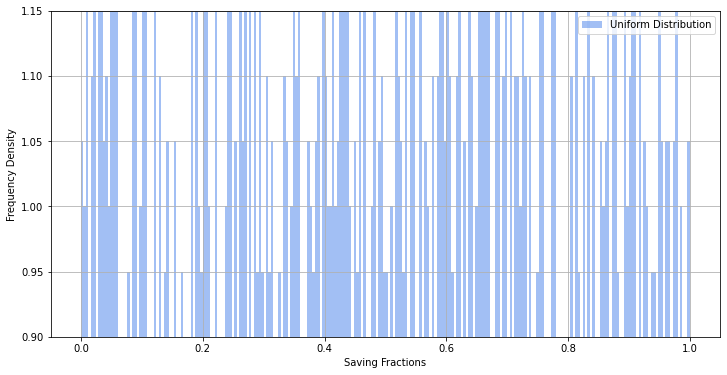

In [27]:
np.random.seed(seed)

wealth_fractions = generate_random(n)
#wealth_fractions = generate_boltzmann_gibbs(n)
#wealth_fractions =generate_bose_einstein(n)

# Normalize to [0, 1]
scaled_wealth_fractions = (wealth_fractions - np.min(wealth_fractions)) / (np.max(wealth_fractions) - np.min(wealth_fractions))
# Sort in descending order (wealth hierarchy) -  wealthier agents save more
sorted_scaled_wealth_fractions = np.sort(scaled_wealth_fractions)[::-1]

# Compute histogram data (but don't plot yet)
counts, bin_edges = np.histogram(sorted_scaled_wealth_fractions, bins=250, density=True)
bin_widths = np.diff(bin_edges)
area = np.sum(counts * bin_widths)

print(f"Total area under the histogram: {area:.6f}")

plt.figure(figsize=(12, 6))
plt.hist(sorted_scaled_wealth_fractions, bins=250, density=True, alpha=0.6, label='Uniform Distribution', color='cornflowerblue')
plt.ylim(0.9, 1.15)  # Adjust this value as needed
plt.xlabel("Saving Fractions")
plt.ylabel("Frequency Density")
plt.legend()
plt.grid()
plt.show()


### INITIAL WEALTH DISTRIBUTION MODEL

In [28]:
def generate_initial_wealth(n, seed, model, lower_bound, upper_bound):
    np.random.seed(seed)
    """ Generate initial wealth matrix using chosen PD.
    Parameters:
    n (int): Number of individuals.
    seed (int): Seed for reproducibility.
    Returns:
    np.ndarray: Sorted 1D array of initial wealth."""

    # # choose a wealth distribution
    if model == 'random':
        wealth = generate_random(n)  # Generate sorted random wealth fractions in descending order

    elif model == 'boltzgibbs':  # Exponential Distribution (Boltzmann-Gibbs)
        wealth = generate_boltzmann_gibbs(n)

    elif model == 'gamma':  # Gamma Distribution
        wealth = generate_gamma(n)

    elif model == 'lognormal':  # Lognormal Distribution
        wealth = generate_lognormal(n)

    elif model == 'pareto':  # Pareto Distribution
        wealth = generate_pareto(n)

    elif model == 'weibull':  # Weibull Distribution
        wealth = generate_weibull(n)

    elif model =='gaussian':
        wealth = generate_gaussian(n)

    elif model =="beta":
        wealth = generate_beta(n)

    elif model == 'ccm':
        wealth = generate_ccm(n)

    elif model == 'kinetic':
        wealth = generate_kinetic_exchange(n)

    elif model == 'burr':
        wealth = generate_burr(n)

    elif model == 'maxwell':
        wealth = generate_maxwell_boltzmann(n)

    elif model == 'bose':
        wealth = generate_bose_einstein(n)

    else:
        raise ValueError("Invalid initial wealth model type")

    # Scale to desired range
    #First equation normalizes before scaling (good for arbitrary wealth values).
    #Second equation assumes wealth is already in [0,1] (direct scaling without normalization).
    #for arbitrary use min max normalization

    wealth = lower_bound + (wealth - np.min(wealth)) / (np.max(wealth) - np.min(wealth)) * (upper_bound - lower_bound)
    #wealth = lower_bound + wealth * (upper_bound - lower_bound)  # Scale to the desired range
    #wealth = np.asarray(wealth)  # Ensure it's an array
    initial_wealth = np.sort(wealth)[::-1]
    
    # # Compute histogram data (but don't plot yet)
    counts, bin_edges = np.histogram(initial_wealth, bins=250, density=True)
    bin_widths = np.diff(bin_edges)
    area = np.sum(counts * bin_widths)

    print(f"Total area under the histogram: {area:.6f}")

    plt.figure(figsize=(10, 6))
    plt.hist(initial_wealth, bins=250, density=True, alpha=0.6, color='purple', label="Agent Wealth Distribution")
    plt.title(f"Wealth Distribution ({model})")
    plt.xlabel("Wealth")
    plt.ylabel("Frequency Density")
    plt.legend()
    plt.grid()
    plt.show()



    return initial_wealth

### SAVING MODELS

In [29]:
def savings(n, model):
    # # choose a savings distribution
    if model == 'random':
        wealth_fractions = generate_random(n)  # Generate sorted random wealth fractions in descending order

    elif model == 'boltzgibbs':  # Exponential Distribution (Boltzmann-Gibbs)
        wealth_fractions = generate_boltzmann_gibbs(n)

    elif model == 'gamma':  # Gamma Distribution
        wealth_fractions = generate_gamma(n)

    elif model == 'lognormal':  # Lognormal Distribution
        wealth_fractions = generate_lognormal(n)

    elif model == 'pareto':  # Pareto Distribution
        wealth_fractions = generate_pareto(n)

    elif model == 'weibull':  # Weibull Distribution
        wealth_fractions = generate_weibull(n)

    elif model =='gaussian':
        wealth_fractions = generate_gaussian(n)

    elif model =="beta":
        wealth_fractions = generate_beta(n)

    elif model == 'ccm':
        wealth_fractions = generate_ccm(n)

    elif model == 'kinetic':
        wealth_fractions = generate_kinetic_exchange(n)

    elif model == 'burr':
        wealth_fractions = generate_burr(n)

    elif model == 'maxwell':
        wealth_fractions = generate_maxwell_boltzmann(n)

    elif model == 'bose':
        wealth_fractions = generate_bose_einstein(n)

    else:
        raise ValueError("Invalid saving model type")


    min_val = np.min(wealth_fractions)
    max_val = np.max(wealth_fractions)

    if min_val==max_val:
        pass
    else:
        wealth_fractions = (wealth_fractions - np.min(wealth_fractions)) / (np.max(wealth_fractions) - np.min(wealth_fractions))
    return wealth_fractions

### INCOME MODELS

In [30]:
def income(n, model):

    # # choose a savings distribution
    if model == 'random':
        income_fractions = generate_random(n)  # Generate sorted random wealth fractions in descending order

    elif model == 'boltzgibbs':  # Exponential Distribution (Boltzmann-Gibbs)
        income_fractions = generate_boltzmann_gibbs(n)

    elif model == 'gamma':  # Gamma Distribution
        income_fractions = generate_gamma(n)

    elif model == 'lognormal':  # Lognormal Distribution
        income_fractions = generate_lognormal(n)

    elif model == 'pareto':  # Pareto Distribution
        income_fractions = generate_pareto(n)

    elif model == 'weibull':  # Weibull Distribution
        income_fractions = generate_weibull(n)

    elif model =='gaussian':
        income_fractions = generate_gaussian(n)

    elif model =="beta":
        income_fractions = generate_beta(n)

    elif model == 'ccm':
        income_fractions = generate_ccm(n)

    elif model == 'kinetic':
        income_fractions = generate_kinetic_exchange(n)

    elif model == 'burr':
        income_fractions = generate_burr(n)

    elif model == 'maxwell':
        income_fractions = generate_maxwell_boltzmann(n)

    elif model == 'bose':
        income_fractions = generate_bose_einstein(n)

    else:
        raise ValueError("Invalid income model type")

    min_val = np.min(income_fractions)
    max_val = np.max(income_fractions)

    if min_val==max_val:
        pass
    else:
        income_fractions = (income_fractions - np.min(income_fractions)) / (np.max(income_fractions) - np.min(income_fractions))
    return income_fractions

## Income Circulation Matrix

### ORIGIN ICM AND SAVING DISTRIBUTIONS
#### Matrix diagonal elements sourced from a saving distribution

### Note

Wealthy Agents save more therefore the saving fractions will be sourced from a random distribution but will be sorted.


The income and saving arrays are normalised to be scaled between 1 and 0 through min max

epsilon is added at the end to avoid divisions by 0

In [31]:
# Rows are Incomes + Savings, Columns are Expenses + Savings as F[i,j] means fraction of wealth J -> I

def generate_F0(n, interact, tc, bc, seed, model, model2):
    np.random.seed(seed)  # Set random seed for reproducibility
    F = np.zeros((n, n))  # Initialize an n x n matrix with zeros

    ### make the random fractions be sourced from an expense dist for j

    wealth_fractions = savings(n,model)

    # Sort in descending order (wealth hierarchy) -  wealthier agents save more

    wealth_fractions = np.sort(wealth_fractions)[::-1]


    interacting = int(n * interact / 100)  # Calculate the number of interacting agents

    for j in range(n):
        F[j, j] = wealth_fractions[j]  # Assign wealth fraction to the diagonal element

        if (interacting > 0):
            all_indices = list(range(n))  # Create a list of all indices
            all_indices.remove(j)  # Remove the current index j
            interacting_indices = np.random.choice(all_indices, interacting, replace=False)  # Randomly select interacting agents
            
            random_fractions = income(interacting, model2)  # Generate random fractions for interacting agents from different dist.
            
            #random_fractions+= 1e-8
            random_fractions /= random_fractions.sum()  # Normalize fractions to sum to 1
            random_fractions *= (1 - wealth_fractions[j])  # Scale by remaining wealth
            F[interacting_indices, j] = random_fractions  # Assign fractions to the selected indices

    # other economic interactions

    # Determine the top 10% of rows based on wealth fractions
    top_10_percent_indices = np.arange(int(n * 0.1))

    for i in top_10_percent_indices:
        zero_indices = np.where(F[i] == 0)[0]  # Find indices of zero elements
        num_to_change = int(len(zero_indices) * tc / 100)  # Calculate the number of elements to change

        if num_to_change > 0:
            elements_to_change = np.random.choice(zero_indices, num_to_change, replace=False)  # Select elements to change
            F[i, elements_to_change] = np.random.rand(num_to_change) / n  # Assign random values between 0 and 1/n

    # Determine the bottom 10% of rows based on wealth fractions
    bottom_10_percent_indices = np.arange(int(n * 0.9), n)

    for i in bottom_10_percent_indices:
        non_zero_indices = np.where((F[i] != 0) & (np.arange(n) != i))[0]  # Find indices of non-zero elements excluding diagonal
        num_to_zero = int(len(non_zero_indices) * bc / 100)  # Calculate the number of elements to set to zero

        if num_to_zero > 0:
            elements_to_zero = np.random.choice(non_zero_indices, num_to_zero, replace=False)  # Select elements to set to zero
            F[i, elements_to_zero] = 0  # Set selected elements to zero

    # Normalize each column to ensure the final matrix is column stochastic
    for j in range(n):
        F[:, j] += 1e-8  # Add small value to prevent zero sum epsilon to add a probability
        F[:, j] /= F[:, j].sum()  # Normalize the column to sum to 1

    return F 

## Income Circulation Matrix at time T
### All ICM generation for set steps S

##### Saving Elements Modification
1) Technically one could change the saving elements (ajj) on the diagonal to follow certain distributions or patterns.

    - Economically, whether savings should be treated separately or randomized with other wealth exchanges depends on the model's assumptions. If savings are viewed as stable, long-term preferences (e.g., a fixed percentage of wealth), then they should be kept separate and adjusted deterministically. This reflects rational saving behavior.

    - On the other hand, if savings are considered to fluctuate with short-term factors (like income changes or economic conditions), then it makes sense to randomize savings along with other wealth exchanges. Randomizing savings reflects a more dynamic, realistic model where agents' savings rates can change due to various external factors. The decision hinges on whether you want a stable savings behavior or a model that reflects short-term economic fluctuations.

2) One could also use ajj to weigh the variations or changes in the elements in a column. Multiplied into the percentage fluctuations for elements.

3) As each column j represents a fractional wealth vector for agent j and sums to 1, these saving elements could determine the rest of the fractional exchanges with the limiting 1-ajj.

4) These randomizations can be applied to the small changes the ICM goes through at each timestep to mimic real world behavior.

In [32]:
# Function to generate Ft matrix
def generate_Ft(F_prev, a, b, c, step_seed):
    np.random.seed(step_seed)
    n = F_prev.shape[0] # number of rows of prev matrix
    F_new = F_prev.copy()
    num_columns_to_modify = int(a * n / 100)
    columns_to_modify = np.random.choice(n, num_columns_to_modify, replace=False)

    for j in columns_to_modify:

        #ajj = F_prev[j, j]
        # what can we do about the ajj element? Look at the markdown above

        num_elements_to_modify = int(b * n / 100)
        elements_to_modify = np.random.choice(n, num_elements_to_modify, replace=False)

        for i in elements_to_modify:

            # c cannot be the % change to the element as if element is 0, it will never be changed
            # Calculate the percentage change as a multiplier
            # change_factor = 1 + np.random.uniform(-c / 100, c / 100)
            # Apply the change directly as a scaling factor
            # F_new[i, j] = min(max(F_new[i, j] * change_factor, 0), 1)

            random_change = np.random.uniform(-c / 100, c / 100)
            F_new[i, j] = min(max(F_new[i, j] + random_change, 0), 1)

        F_new[:, j] /= F_new[:, j].sum()

    return F_new


# Function to generate all Ft matrices
def generate_all_Ft(F0, S, a, b, c, seed):
    F_matrices = [F0]
    for t in range(1, S + 1):
        step_seed = seed + t
        F_new = generate_Ft(F_matrices[-1], a, b, c, step_seed)
        
        F_matrices.append(F_new)
    return F_matrices


# To ensure that the F(t) matrices at all steps are irreducible, stochastic, and non-negative, we
# added specific checks in our code. The function is non negative(F) verifies that all elements are non-negative. The function is column stochastic(F) checks that all columns
# sum to 1. Finally, the function is irreducible(F) ensures that the matrix is irreducible
# by checking that there is only one strongly connected component in the graph representation
# of the matrix. For this purpose, we used the connected components function from the
# 22
# scipy.sparse.csgraph library, which is based on the algorithm presented by Pearce (2005)
# for finding strongly connected components in a directed graph (Pearce, 2005). The implementation details and further documentation can be found in the SciPy library documentation (SciPy
# Developers, n.d.).

# Function to verify these matrix properties

def is_non_negative(F):
    return np.all(F >= 0)

def is_column_stochastic(F):
    return np.allclose(F.sum(axis=0), np.ones(F.shape[1]))

def is_irreducible(F):
    _, labels = connected_components(csgraph=F, directed=True, connection='strong')
    return np.unique(labels).size == 1

def check_Ft_properties(F_matrices):
    results = []
    for i, F in enumerate(F_matrices):
        non_negative = is_non_negative(F)
        column_stochastic = is_column_stochastic(F)
        irreducible = is_irreducible(F)

        satisfies_all = non_negative and column_stochastic and irreducible
        results.append({
            'Matrix Index': i,
            'Non-negative': non_negative,
            'Column Stochastic': column_stochastic,
            'Irreducible': irreducible,
            'Satisfies All Properties': satisfies_all
        })
    print(results)

      # Commented out for efficiency  
#     # Print results
#     for result in results:
#         print(f"Matrix F[{result['Matrix Index']}] -> Non-negative: {result['Non-negative']}, Column Stochastic: {result['Column Stochastic']}, Irreducible: {result['Irreducible']}")
#         if result['Satisfies All Properties']:
#             print(f"Matrix F[{result['Matrix Index']}] satisfies all properties!")
#         else:
#             print(f"Matrix F[{result['Matrix Index']}] does not satisfy all properties!")

#     # Check overall satisfaction
#     if all(result['Satisfies All Properties'] for result in results):
#         print("All matrices satisfy all conditions.")
#     else:
#         print("The following matrices do not satisfy all conditions:")
#         for result in results:
#             if not result['Satisfies All Properties']:
#                 print(f"- Matrix F[{result['Matrix Index']}]")
                
                


### ICM Row Behavior - Top X and Bottom Y Percent

In [33]:
def sum_rows_of_matrices(matrices,x,y,injection_step):
    # Determine the number of rows from the first matrix

    # Create an empty list to store row sums
    row_sums = []

    # Iterate over each matrix and compute row sums
    for matrix in matrices:
        row_sums.append(np.sum(matrix, axis=1))

    # Convert the list of row sums into a DataFrame
    row_sums = np.column_stack(row_sums)
    df = pd.DataFrame(row_sums, columns=[f'{i}' for i in range(len(matrices))])

    # Determine the threshold values for the top x% and bottom y%
    top_threshold = np.percentile(df.values, 100 - x)
    bottom_threshold = np.percentile(df.values, y)

    # Filter rows in the top x% or bottom y%
    top_df = df[(df >= top_threshold).any(axis=1)]
    bottom_df = df[(df <= bottom_threshold).any(axis=1)]

    # Compute total sum of top X% and bottom Y% across timesteps
    top_sums = top_df.sum()
    bottom_sums = bottom_df.sum()
    #top_avg = top_df.mean()
    #bottom_avg = bottom_df.mean()


    # Plot Top X% Sums
    plt.figure(figsize=(13, 6))
    plt.plot(top_sums.index, top_sums.values, marker='o', linestyle='-', label=f'Top {x}% Sum')
    plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
    plt.xlabel("ICM Timestep")
    plt.ylabel("Total Income Sum")
    plt.title(f"Total Sum of Top {x}% Agent Incomes Across ICM")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Bottom Y% Sums
    plt.figure(figsize=(13, 6))
    plt.plot(bottom_sums.index, bottom_sums.values, marker='s', linestyle='--', label=f'Bottom {y}% Sum')
    plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
    plt.xlabel("ICM Timestep")
    plt.ylabel("Total Income Sum")
    plt.title(f"Total Sum of Bottom {y}% Agent Incomes Across ICM")
    plt.legend()
    plt.grid()
    plt.show()
    
    
# Commented out and but can analysed by modellers to see behaviour, commented for efficiency as both sum and average showed same mechanics
#     # Plot Top X% Averages
#     plt.figure(figsize=(10, 6))
#     plt.plot(top_avg.index, top_avg.values, marker='o', linestyle='-', label=f'Top {x}% Avg')
#     plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
#     plt.xlabel("ICM Timestep")
#     plt.ylabel("Average Income Sum")
#     plt.title(f"Average Sum of Top {x}% Agent Incomes Across ICM")
#     plt.legend()
#     plt.grid()
#     plt.show()

#     # Plot Bottom Y% Averages
#     plt.figure(figsize=(10, 6))
#     plt.plot(bottom_avg.index, bottom_avg.values, marker='s', linestyle='--', label=f'Bottom {y}% Avg')
#     plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
#     plt.xlabel("ICM Timestep")
#     plt.ylabel("Average Income Sum")
#     plt.title(f"Average Sum of Bottom {y}% Agent Incomes Across ICM")
#     plt.legend()
#     plt.grid()
#     plt.show()

#     df2 = df.add_prefix("ICM_TimeStep_")
#     print(df2)


## Epsilon and fractional wealth injection from HNW to LNW

## Wealth Matrix Generation
### ICM for steps applied to Initial Wealth

In [34]:
# Function to generate wealth matrices X(t)
def generate_wealth_matrices(X0, F_matrices):
    X_matrices = [X0]
    for t in range(1, len(F_matrices)+1):
        X_new = np.dot(F_matrices[t-1], X_matrices[-1])
        X_matrices.append(X_new)
    return X_matrices

## Wealth Vector Analysis

In [35]:
def calculate_top_bottom_wealth(X_matrices, top_percent, bottom_percent):
    results = []  # Initialize an empty list to store the results

    for t, X in enumerate(X_matrices):  # Loop through each matrix in X_matrices
        num_agents = len(X)  # Get the number of agents (rows in X)
        top_k = int(np.ceil(top_percent / 100 * num_agents))  # Calculate the number of elements in the top_percent
        bottom_k = int(np.ceil(bottom_percent / 100 * num_agents))  # Calculate the number of elements in the bottom_percent

        top_wealth = np.sum(X[:top_k])  # Calculate the total wealth of the top_k rows
        bottom_wealth = np.sum(X[-bottom_k:])  # Calculate the total wealth of the bottom_k rows
        total_wealth = np.sum(X)  # Calculate the total wealth of all rows

        results.append((t, top_wealth, bottom_wealth, total_wealth))  # Append the results as a tuple

    return results

## Epsilon and fractional wealth injection from HNW to LNW

In [36]:
# Function to apply epsilon injection at step injection_step
def apply_epsilon_injection(X, top_percent, bottom_percent, injection_percent):
    num_agents = len(X)  # Get the number of agents (rows in X)

    top_k = int(np.ceil(top_percent / 100 * num_agents))  # Calculate the number of elements in the top_percent
    bottom_k = int(np.ceil(bottom_percent / 100 * num_agents))  # Calculate the number of elements in the bottom_percent

    top_indices = np.arange(top_k)  # Select the indices of the top_k agents (first top_k rows)
    bottom_indices = np.arange(num_agents - bottom_k, num_agents)  # Select the indices of the bottom_k agents (last bottom_k rows)

    total_injection = np.sum(X[:top_k]) * (injection_percent / 100)  # Calculate the total amount to inject by taking injection_percent% of the wealth from the top_k agents

    Xe = X.copy().astype(float)  # Create a copy of X as float to avoid casting issues
    Xe[top_indices] = Xe[top_indices] * (1 - (injection_percent / 100))  # Decrease the wealth of the top_k agents by injection_percent%

    injection_per_agent = total_injection / bottom_k  # Distribute the total_injection amount equally among the bottom_k agents
    Xe[bottom_indices] += injection_per_agent

    return Xe  # Return the modified array

## INITIAL FRACTIONAL WEALTH / INCOME CIRCULATION MATRIX

Total area under the histogram: 1.000000


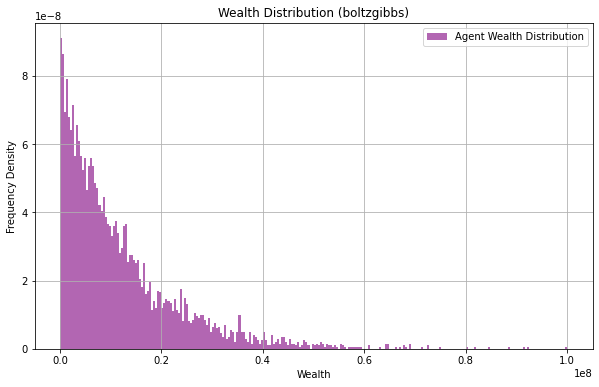

In [37]:
X0 = generate_initial_wealth(n, seed, initial_wealth_model , lower_bound, upper_bound)

## ICM AFTER T TIMESTEPS

In [38]:
F0 = generate_F0(n, interact, tc, bc, f0_seed, saving_distribution, income_distribution)

In [39]:
F_matrices = generate_all_Ft(F0, S, a, b, c, ft_seed)

## ICM Matrix Property Check

In [40]:
check_Ft_properties(F_matrices)

KeyboardInterrupt: 

### ICM Behaviour for Top X and Bottom Y percent Income Sums

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

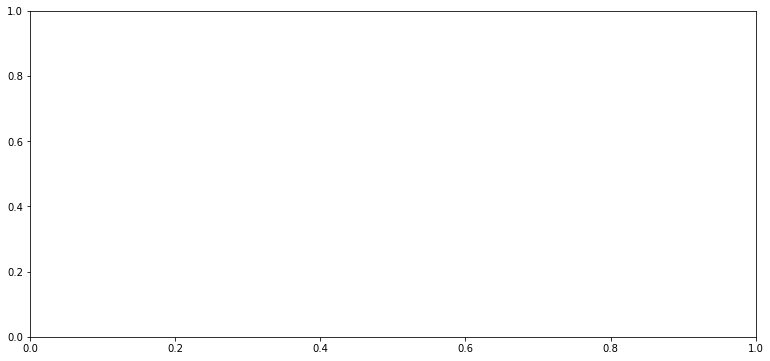

In [ ]:
#sum_rows_of_matrices(F_matrices,top_percent,bottom_percent, injection_step)

In [ ]:
#checks
# print(min(savings(n,saving_distribution)))
# print(max(savings(n,saving_distribution)))
# print(min(income(n,income_distribution)))
# print(max(income(n,income_distribution)))
# print(min(income(n,income_distribution)))
# print(max(income(n,income_distribution)))
# print(min(generate_initial_wealth(n, seed, initial_wealth_model, lower_bound, upper_bound)))
# print(max(generate_initial_wealth(n, seed, initial_wealth_model, lower_bound, upper_bound)))

## WEALTH MATRICES

In [ ]:
X_matrices = generate_wealth_matrices(X0, F_matrices)

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
window_size = 100  # Adjust the window size as needed for smoothing

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[0].flatten(), window_size), label='X0', linestyle='-', color="navy")
# plt.xlabel('Agent Number')
# plt.ylabel('Wealth')
# plt.title('Wealth Distribution for Initial Wealth Distrubution X(0) (Smoothed)')
# plt.legend()
# plt.grid(True)
# plt.show()

# MONETARY CIRCULATION INITIATED WITH WEALTH INJECTION AT STEP

In [ ]:
X_injection = X_matrices[injection_step]
X_epsilon = apply_epsilon_injection(X_injection, top_percent, bottom_percent, injection_percent)

In [ ]:
X_matrices_with_injection = X_matrices[:injection_step] + [X_epsilon] + generate_wealth_matrices(X_epsilon, F_matrices[injection_step:])[1:]

### ICM Behaviour for Top X and Bottom Y percent Income Sums with Wealth Injection

In [ ]:
injection_step_c = 0

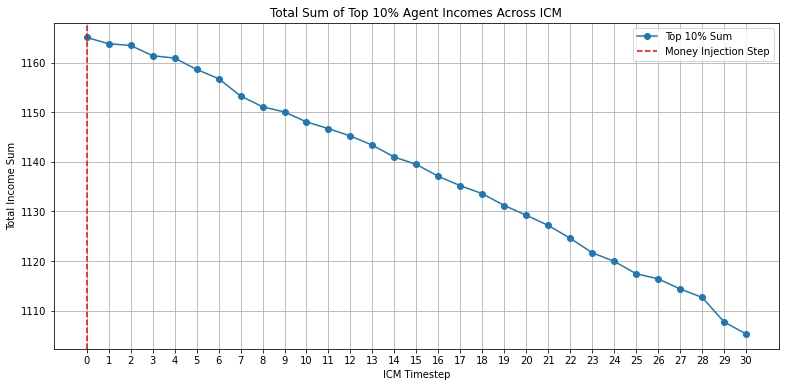

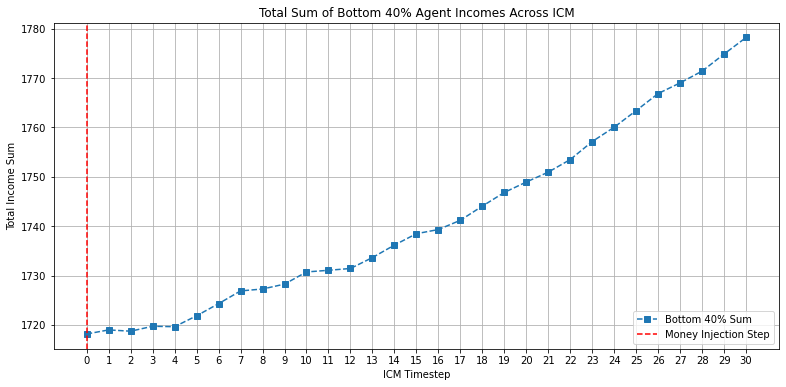

In [ ]:
sum_rows_of_matrices(F_matrices[injection_step:],top_percent,bottom_percent, injection_step_c)

# HNW AND LNW WEALTH WITH AND WITHOUT INJECTION

In [ ]:
top_bottom_wealth_no_injection = calculate_top_bottom_wealth(X_matrices,top_percent,bottom_percent)
top_bottom_wealth_with_injection = calculate_top_bottom_wealth(X_matrices_with_injection,top_percent,bottom_percent)

In [ ]:
# WITH MONETARY INJECTION
column_name_top_percent = f"Top {top_percent}% Wealth (With Money Injection)"
column_name_bottom_percent = f"Bottom {bottom_percent}% Wealth (With Money Injection)"
df_results_with_injection = pd.DataFrame(top_bottom_wealth_with_injection, columns=['Step Number', column_name_top_percent, column_name_bottom_percent, 'Total Wealth (With Money Injection)'])

In [ ]:
# WITHOUT MONETARY INJECTION
column_name_top_percent_noeps = f"Top {top_percent}% Wealth (No Money Injection)"
column_name_bottom_percent_noeps = f"Bottom {bottom_percent}% Wealth (No Money Injection)"
df_results_no_injection = pd.DataFrame(top_bottom_wealth_no_injection, columns=['Step Number', column_name_top_percent_noeps, column_name_bottom_percent_noeps, 'Total Wealth (No Money Injection)'])

# RESULTS

In [ ]:
df_results_merged = pd.merge(df_results_no_injection, df_results_with_injection, on='Step Number')

# PLOTS

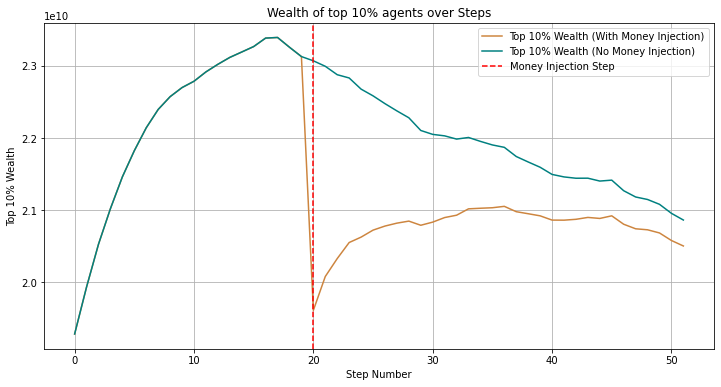

In [ ]:
# Plot the results for top % wealth in one graph
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], df_results_merged[column_name_top_percent], label=f'Top {top_percent}% Wealth (With Money Injection)', color='peru')
plt.plot(df_results_merged['Step Number'], df_results_merged[column_name_top_percent_noeps], label=f'Top {top_percent}% Wealth (No Money Injection)', color='teal')
plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Top {top_percent}% Wealth')
plt.title(f'Wealth of top {top_percent}% agents over Steps')
plt.legend()
plt.grid(True)
plt.show()

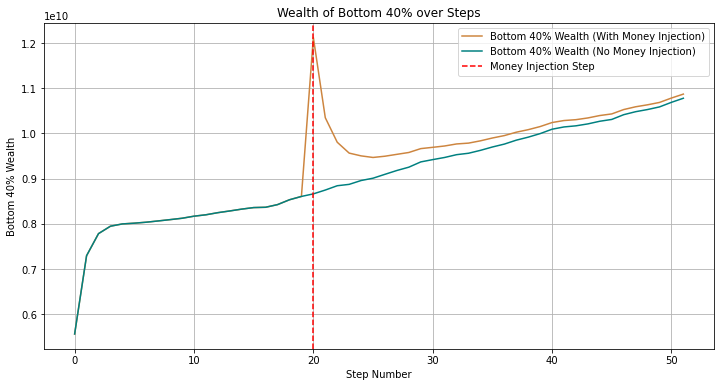

In [ ]:
# Plot the results for bottom % wealth in another graph
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], df_results_merged[column_name_bottom_percent], label=f'Bottom {bottom_percent}% Wealth (With Money Injection)', color="peru")
plt.plot(df_results_merged['Step Number'], df_results_merged[column_name_bottom_percent_noeps], label=f'Bottom {bottom_percent}% Wealth (No Money Injection)', color="teal")
plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Bottom {bottom_percent}% Wealth')
plt.title(f'Wealth of Bottom {bottom_percent}% over Steps')
plt.legend()
plt.grid(True)
plt.show()

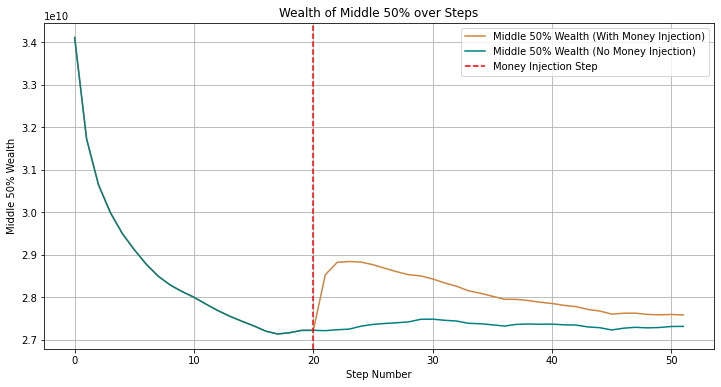

In [ ]:
def middle_wealth(X_matrices, top_percent, bottom_percent):
    results = []  # Initialize an empty list to store the results

    for t, X in enumerate(X_matrices):  # Loop through each matrix in X_matrices
        num_agents = len(X)  # Get the number of agents (rows in X)
        top_k = int(np.ceil(top_percent / 100 * num_agents))  # Calculate the number of elements in the top_percent
        bottom_k = int(np.ceil(bottom_percent / 100 * num_agents))  # Calculate the number of elements in the bottom_percent
        middle_start = top_k
        middle_end = num_agents - bottom_k
        middle_wealth = np.sum(X[middle_start:middle_end])  # Calculate the total wealth of the top_k rows
        total_wealth = np.sum(X)  # Calculate the total wealth of all rows

        results.append((t, middle_wealth, total_wealth))  # Append the results as a tuple

    return results


mid_wealth_no_inj = middle_wealth(X_matrices, top_percent, bottom_percent)
mid_wealth_inj = middle_wealth(X_matrices_with_injection, top_percent, bottom_percent)

mid_percent = 100-bottom_percent-top_percent

# WITH MONETARY INJECTION
column_name_middle = f"Middle {mid_percent}% Wealth (With Money Injection)"
mid_results_with_injection = pd.DataFrame(mid_wealth_inj, columns=['Step Number', column_name_middle, 'Total Wealth (With Money Injection)'])

# WITHOUT MONETARY INJECTION
column_name_middle_noeps = f"Middle {mid_percent}% Wealth (No Money Injection)"
mid_results_no_injection = pd.DataFrame(mid_wealth_no_inj, columns=['Step Number', column_name_middle_noeps, 'Total Wealth (No Money Injection)'])



df_results2 = pd.merge(mid_results_no_injection, mid_results_with_injection, on='Step Number')

# Plot the results for bottom % wealth in another graph
plt.figure(figsize=(12, 6))
plt.plot(df_results2['Step Number'], df_results2[column_name_middle], label=f'Middle {mid_percent}% Wealth (With Money Injection)', color="peru")
plt.plot(df_results2['Step Number'], df_results2[column_name_middle_noeps], label=f'Middle {mid_percent}% Wealth (No Money Injection)', color="teal")
plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Middle {mid_percent}% Wealth')
plt.title(f'Wealth of Middle {mid_percent}% over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TOTAL PLOT WITH VARYING diff injection %

In [ ]:
X_epsilon1 = apply_epsilon_injection(X_injection, 10, 40, 5)
X_epsilon2 = apply_epsilon_injection(X_injection, 10, 40, 15)
X_epsilon3 = apply_epsilon_injection(X_injection, 10, 40, 25)

X_matrices_with_injection1 = X_matrices[:injection_step] + [X_epsilon1] + generate_wealth_matrices(X_epsilon1, F_matrices[injection_step:])[1:]
X_matrices_with_injection2 = X_matrices[:injection_step] + [X_epsilon2] + generate_wealth_matrices(X_epsilon2, F_matrices[injection_step:])[1:]
X_matrices_with_injection3 = X_matrices[:injection_step] + [X_epsilon3] + generate_wealth_matrices(X_epsilon3, F_matrices[injection_step:])[1:]


top_bottom_wealth_no_injection = calculate_top_bottom_wealth(X_matrices,10,40)
top_bottom_wealth_with_injection1 = calculate_top_bottom_wealth(X_matrices_with_injection1,10,40)
top_bottom_wealth_with_injection2 = calculate_top_bottom_wealth(X_matrices_with_injection2,10,40)
top_bottom_wealth_with_injection3 = calculate_top_bottom_wealth(X_matrices_with_injection3,10,40)

# WITH MONETARY INJECTION
df_results_with_injection1 = pd.DataFrame(top_bottom_wealth_with_injection1, columns=['Step Number', 
                                                                                     "Top 10% Wealth (With 5% Money Injection)",
                                                                                     "Bottom 40% Wealth (With 5% Money Injection)",
                                                                                     'Total Wealth (With 5% Money Injection)'])

df_results_with_injection2 = pd.DataFrame(top_bottom_wealth_with_injection2, columns=['Step Number', 
                                                                                     "Top 10% Wealth (With 15% Money Injection)",
                                                                                     "Bottom 40% Wealth (With 15% Money Injection)",
                                                                                     'Total Wealth (With 15% Money Injection)'])

df_results_with_injection3 = pd.DataFrame(top_bottom_wealth_with_injection3, columns=['Step Number', 
                                                                                     "Top 10% Wealth (With 25% Money Injection)",
                                                                                     "Bottom 40% Wealth (With 25% Money Injection)",
                                                                                     'Total Wealth (With 25% Money Injection)'])


# WITHOUT MONETARY INJECTION
df_results_no_injection = pd.DataFrame(top_bottom_wealth_no_injection, columns=['Step Number',
                                                                                "Top 10% Wealth (No Money Injection)", 
                                                                                "Bottom 40% Wealth (No Money Injection)",
                                                                                'Total Wealth (No Money Injection)'])


df_results_merged = pd.merge(df_results_no_injection, df_results_with_injection1, on='Step Number')
df_results_merged2 = pd.merge(df_results_merged, df_results_with_injection2, on='Step Number')
df_results_merged3 = pd.merge(df_results_merged2, df_results_with_injection3, on='Step Number')




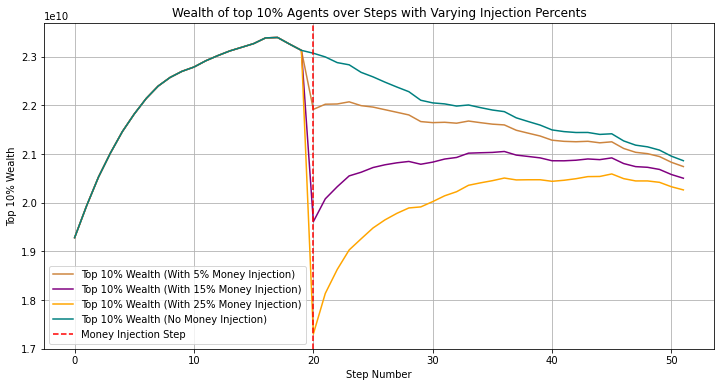

In [ ]:
# Plot the results for top % wealth in one graph
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Top 10% Wealth (With 5% Money Injection)"], label='Top 10% Wealth (With 5% Money Injection)', color='peru')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Top 10% Wealth (With 15% Money Injection)"], label='Top 10% Wealth (With 15% Money Injection)', color='purple')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Top 10% Wealth (With 25% Money Injection)"], label='Top 10% Wealth (With 25% Money Injection)', color='orange')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Top 10% Wealth (No Money Injection)"], label='Top 10% Wealth (No Money Injection)', color='teal')


plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel('Top 10% Wealth')
plt.title('Wealth of top 10% Agents over Steps with Varying Injection Percents')
plt.legend()
plt.grid(True)
plt.show()

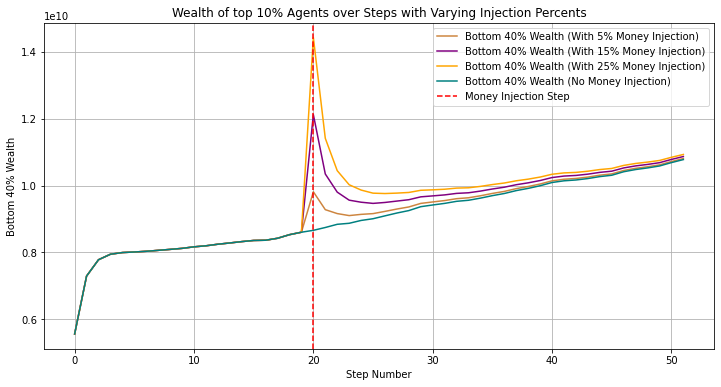

In [ ]:
# Plot the results for top % wealth in one graph
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Bottom 40% Wealth (With 5% Money Injection)"], label='Bottom 40% Wealth (With 5% Money Injection)', color='peru')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Bottom 40% Wealth (With 15% Money Injection)"], label='Bottom 40% Wealth (With 15% Money Injection)', color='purple')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Bottom 40% Wealth (With 25% Money Injection)"], label='Bottom 40% Wealth (With 25% Money Injection)', color='orange')
plt.plot(df_results_merged3['Step Number'], df_results_merged3["Bottom 40% Wealth (No Money Injection)"], label='Bottom 40% Wealth (No Money Injection)', color='teal')


plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel('Bottom 40% Wealth')
plt.title('Wealth of top 10% Agents over Steps with Varying Injection Percents')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TOTAL PLOT WITH VARYING diff top/bottom %

In [ ]:
X_epsilon1 = apply_epsilon_injection(X_injection, 10, 40, 15)
X_epsilon2 = apply_epsilon_injection(X_injection, 20, 20, 15)
X_epsilon3 = apply_epsilon_injection(X_injection, 1, 10, 15)

X_matrices_with_injection1 = X_matrices[:injection_step] + [X_epsilon1] + generate_wealth_matrices(X_epsilon1, F_matrices[injection_step:])[1:]
X_matrices_with_injection2 = X_matrices[:injection_step] + [X_epsilon2] + generate_wealth_matrices(X_epsilon2, F_matrices[injection_step:])[1:]
X_matrices_with_injection3 = X_matrices[:injection_step] + [X_epsilon3] + generate_wealth_matrices(X_epsilon3, F_matrices[injection_step:])[1:]


top_bottom_wealth_no_injection1 = calculate_top_bottom_wealth(X_matrices,10,40)
top_bottom_wealth_no_injection2 = calculate_top_bottom_wealth(X_matrices,20,20)
top_bottom_wealth_no_injection3 = calculate_top_bottom_wealth(X_matrices,1,10)

top_bottom_wealth_with_injection1 = calculate_top_bottom_wealth(X_matrices_with_injection1,10,40)
top_bottom_wealth_with_injection2 = calculate_top_bottom_wealth(X_matrices_with_injection2,20,20)
top_bottom_wealth_with_injection3 = calculate_top_bottom_wealth(X_matrices_with_injection3,1,10)

# WITH MONETARY INJECTION
df_results_with_injection1 = pd.DataFrame(top_bottom_wealth_with_injection1, columns=['Step Number', 
                                                                                     "Top 10% Wealth (With 15% Money Injection)",
                                                                                     "Bottom 40% Wealth (With 15% Money Injection)",
                                                                                     'Total Wealth (With 15% Money Injection)1'])

df_results_with_injection2 = pd.DataFrame(top_bottom_wealth_with_injection2, columns=['Step Number', 
                                                                                     "Top 20% Wealth (With 15% Money Injection)",
                                                                                     "Bottom 20% Wealth (With 15% Money Injection)",
                                                                                     'Total Wealth (With 15% Money Injection)2'])

df_results_with_injection3 = pd.DataFrame(top_bottom_wealth_with_injection3, columns=['Step Number', 
                                                                                     "Top 1% Wealth (With 15% Money Injection)",
                                                                                     "Bottom 10% Wealth (With 15% Money Injection)",
                                                                                     'Total Wealth (With 15% Money Injection)3'])


# WITHOUT MONETARY INJECTION
df_results_no_injection1 = pd.DataFrame(top_bottom_wealth_no_injection1, columns=['Step Number',
                                                                                "Top 10% Wealth (No Money Injection)", 
                                                                                "Bottom 40% Wealth (No Money Injection)",
                                                                                'Total Wealth (No Money Injection)1'])

# WITHOUT MONETARY INJECTION
df_results_no_injection2 = pd.DataFrame(top_bottom_wealth_no_injection2, columns=['Step Number',
                                                                                "Top 20% Wealth (No Money Injection)", 
                                                                                "Bottom 20% Wealth (No Money Injection)",
                                                                                'Total Wealth (No Money Injection)2'])

# WITHOUT MONETARY INJECTION
df_results_no_injection3 = pd.DataFrame(top_bottom_wealth_no_injection3, columns=['Step Number',
                                                                                "Top 1% Wealth (No Money Injection)", 
                                                                                "Bottom 10% Wealth (No Money Injection)",
                                                                                'Total Wealth (No Money Injection)3'])


df_results_merged = pd.merge(df_results_no_injection1, df_results_with_injection1, on='Step Number')
df_results_merged2 = pd.merge(df_results_merged, df_results_with_injection2, on='Step Number')
df_results_merged3 = pd.merge(df_results_merged2, df_results_with_injection3, on='Step Number')
df_results_merged4 = pd.merge(df_results_merged3, df_results_no_injection2, on='Step Number')
df_results_merged5 = pd.merge(df_results_merged4, df_results_no_injection3, on='Step Number')


In [ ]:
df_results_merged_top = df_results_merged5[["Step Number", "Top 10% Wealth (No Money Injection)", "Top 10% Wealth (With 15% Money Injection)",
                                        "Top 20% Wealth (No Money Injection)", "Top 20% Wealth (With 15% Money Injection)", 
                                        "Top 1% Wealth (No Money Injection)", "Top 1% Wealth (With 15% Money Injection)"]]

In [ ]:
df_results_merged_bot = df_results_merged5.drop(columns=["Top 10% Wealth (No Money Injection)", "Top 10% Wealth (With 15% Money Injection)",
                                        "Top 20% Wealth (No Money Injection)", "Top 20% Wealth (With 15% Money Injection)", 
                                        "Top 1% Wealth (No Money Injection)", "Top 1% Wealth (With 15% Money Injection)", 'Total Wealth (No Money Injection)3',  'Total Wealth (No Money Injection)2',  'Total Wealth (No Money Injection)1', "Total Wealth (With 15% Money Injection)1", "Total Wealth (With 15% Money Injection)2", "Total Wealth (With 15% Money Injection)3"])

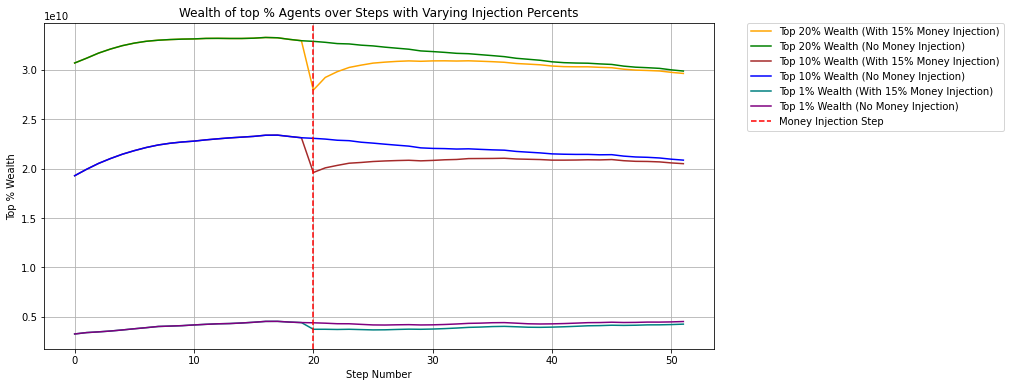

In [ ]:
# Plot the results for top % wealth in one graph
plt.figure(figsize=(12, 6))

plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 20% Wealth (With 15% Money Injection)"], label='Top 20% Wealth (With 15% Money Injection)', color='orange')
plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 20% Wealth (No Money Injection)"], label='Top 20% Wealth (No Money Injection)', color='green')


plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 10% Wealth (With 15% Money Injection)"], label='Top 10% Wealth (With 15% Money Injection)', color='brown')
plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 10% Wealth (No Money Injection)"], label='Top 10% Wealth (No Money Injection)', color='blue')



plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 1% Wealth (With 15% Money Injection)"], label='Top 1% Wealth (With 15% Money Injection)', color='teal')
plt.plot(df_results_merged_top['Step Number'], df_results_merged_top["Top 1% Wealth (No Money Injection)"], label='Top 1% Wealth (No Money Injection)', color='purple')



plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel('Top % Wealth')
plt.title('Wealth of top % Agents over Steps with Varying Injection Percents')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.show()

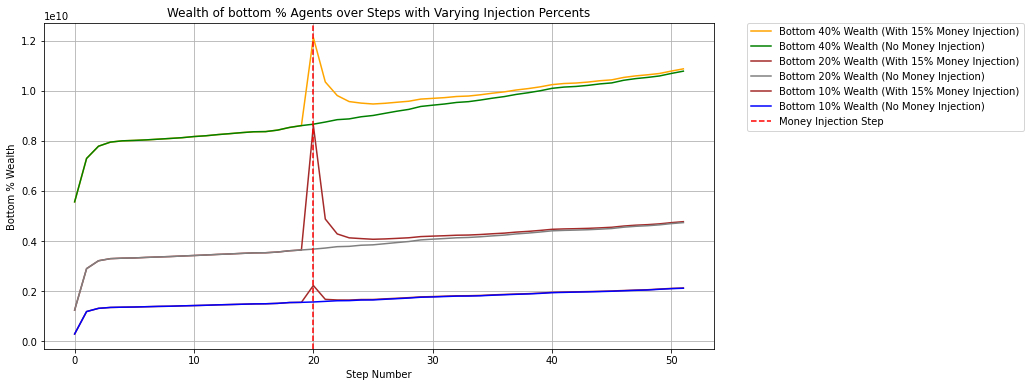

In [ ]:
# Plot the results for top % wealth in one graph
plt.figure(figsize=(12, 6))

plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 40% Wealth (With 15% Money Injection)"], label='Bottom 40% Wealth (With 15% Money Injection)', color='orange')
plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 40% Wealth (No Money Injection)"], label='Bottom 40% Wealth (No Money Injection)', color='green')


plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 20% Wealth (With 15% Money Injection)"], label='Bottom 20% Wealth (With 15% Money Injection)', color='brown')
plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 20% Wealth (No Money Injection)"], label='Bottom 20% Wealth (No Money Injection)', color='grey')


plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 10% Wealth (With 15% Money Injection)"], label='Bottom 10% Wealth (With 15% Money Injection)', color='brown')
plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Bottom 10% Wealth (No Money Injection)"], label='Bottom 10% Wealth (No Money Injection)', color='blue')



# plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Top 1% Wealth (With 15% Money Injection)"], label='Top 1% Wealth (With 15% Money Injection)', color='teal')
# plt.plot(df_results_merged_bot['Step Number'], df_results_merged_bot["Top 1% Wealth (No Money Injection)"], label='Top 1% Wealth (No Money Injection)', color='purple')



plt.axvline(x=injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel('Bottom % Wealth')
plt.title('Wealth of bottom % Agents over Steps with Varying Injection Percents')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.show()

# Statistics

Note, most viz are commented out to improve efficiency. Uncomment for analysis.

### Plot of X_Matrices

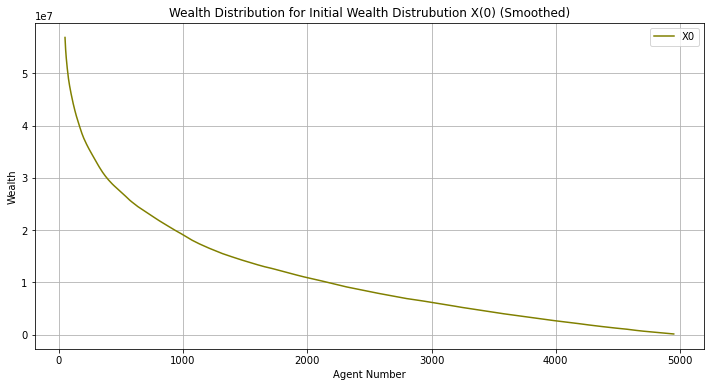

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[0].flatten(), window_size), label='X0', linestyle='-', color="olive")
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Initial Wealth Distrubution X(0) (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

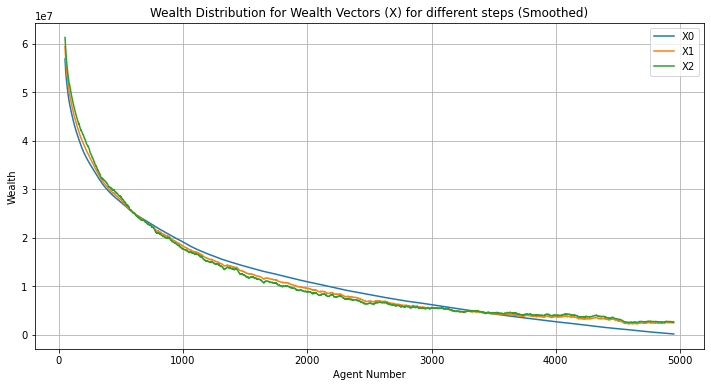

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[0].flatten(), window_size), label=f'X{0}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[1].flatten(), window_size), label=f'X{1}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[2].flatten(), window_size), label=f'X{2}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) for different steps (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

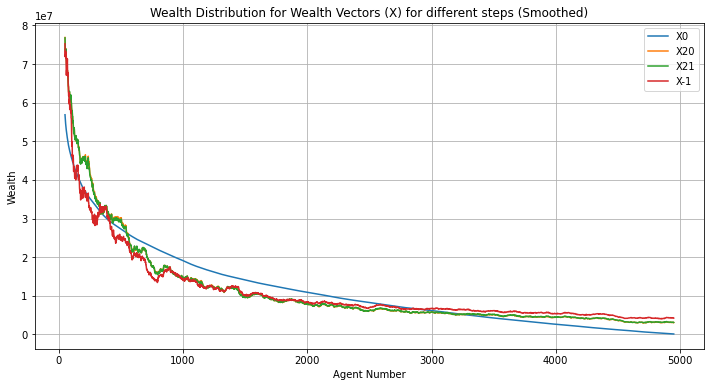

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[0].flatten(), window_size), label=f'X{0}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[injection_step].flatten(), window_size), label=f'X{injection_step}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[injection_step+1].flatten(), window_size), label=f'X{injection_step+1}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[-1].flatten(), window_size), label=f'X{-1}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) for different steps (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

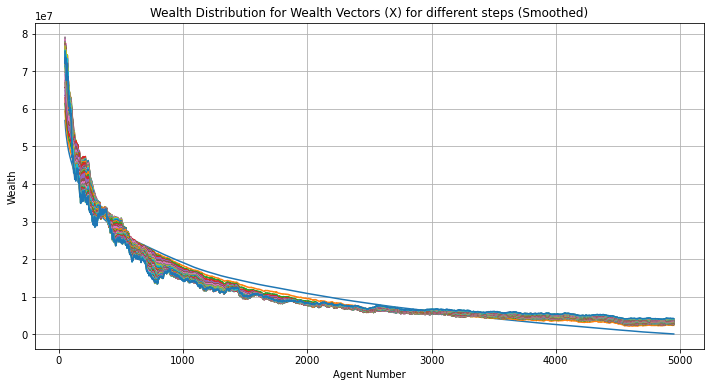

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[N].flatten(), window_size), label='X(N)', linestyle='-')
for p in range(0,S+1):
    plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[p].flatten(), window_size), label=f'X{p}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) for different steps (Smoothed)')
#plt.legend()
plt.grid(True)
plt.show()

### Plots of X Matrices with Wealth Redistribution.

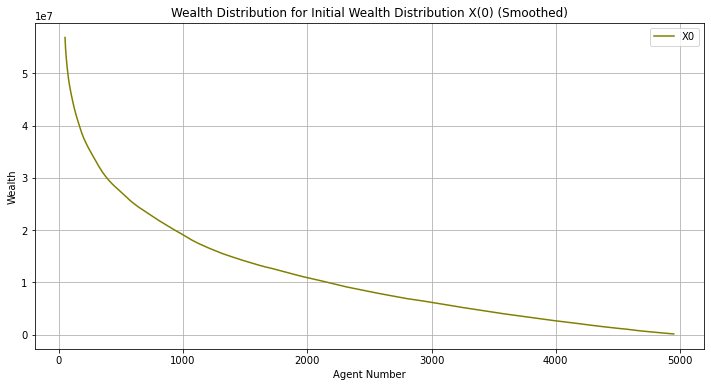

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[0].flatten(), window_size), label='X0', linestyle='-', color='olive')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Initial Wealth Distribution X(0) (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

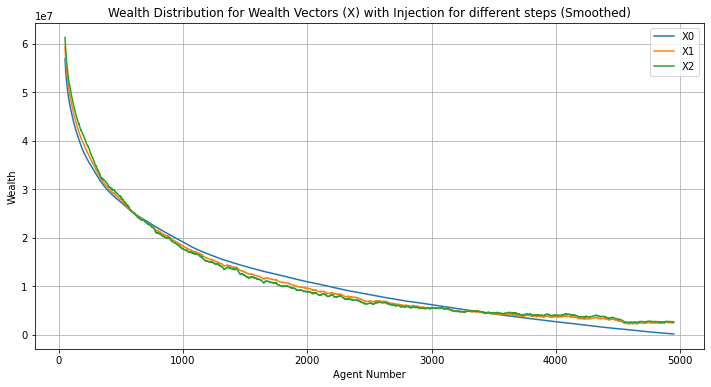

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[0].flatten(), window_size), label=f'X{0}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[1].flatten(), window_size), label=f'X{1}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[2].flatten(), window_size), label=f'X{2}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) with Injection for different steps (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

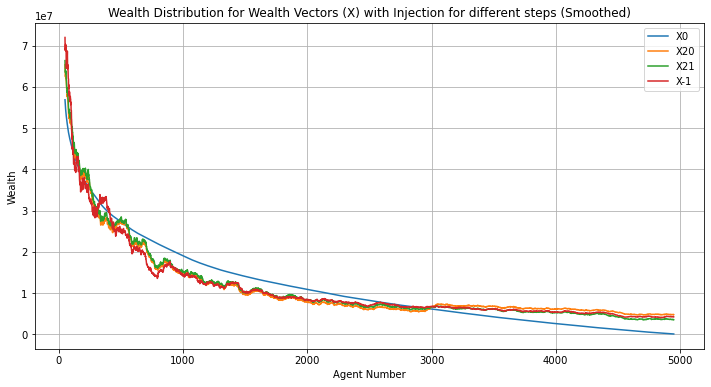

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[0].flatten(), window_size), label=f'X{0}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[injection_step].flatten(), window_size), label=f'X{injection_step}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[injection_step+1].flatten(), window_size), label=f'X{injection_step+1}', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[-1].flatten(), window_size), label=f'X{-1}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) with Injection for different steps (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

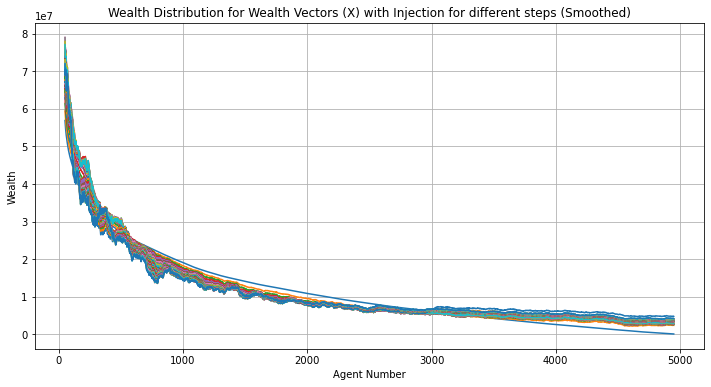

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[N].flatten(), window_size), label='X(N)', linestyle='-')
for p in range(0,S+1):
    plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[p].flatten(), window_size), label=f'X{p}', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for Wealth Vectors (X) with Injection for different steps (Smoothed)')
#plt.legend()
plt.grid(True)
plt.show()

### PLOTS OF WEALTH WITH AND WITHOUT INJECTION AT DIFF TIMESTEPS after Injection Step

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


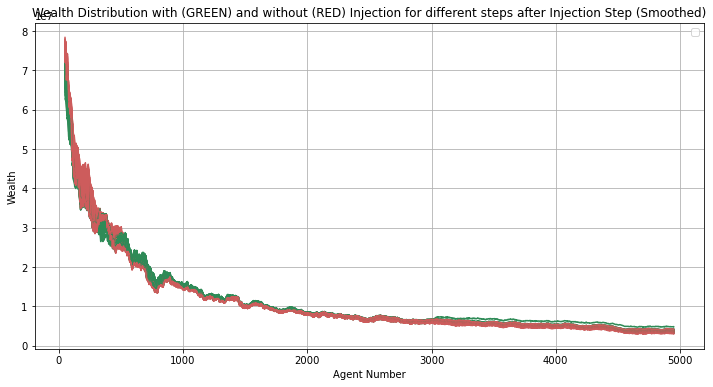

In [ ]:
# Note before Injection Step, both Xmatrices will be same

plt.figure(figsize=(12, 6))
for p in range(injection_step,S+1):
    plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[p].flatten(), window_size), linestyle='-', color='seagreen')
    plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[p].flatten(), window_size), linestyle='-', color='indianred')

plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution with (GREEN) and without (RED) Injection for different steps after Injection Step (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

# PLOTS OF MONETARY INJECTION

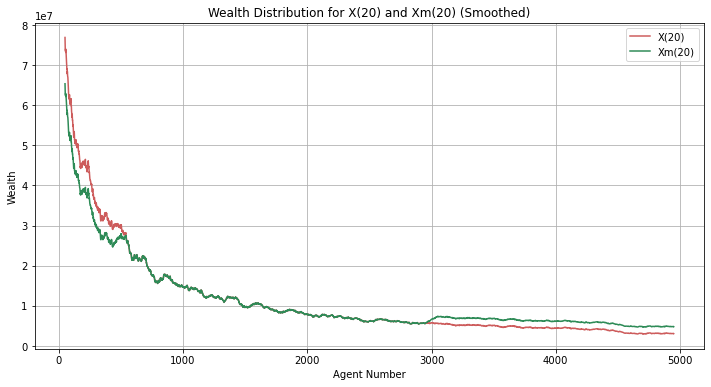

In [ ]:
# Plot X(injection_step) and Xepsilon
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_injection.flatten(), window_size), label=f'X({injection_step})', linestyle='-', color="indianred")
plt.plot(moving_average(range(n), window_size), moving_average(X_epsilon.flatten(), window_size), label=f'Xm({injection_step})', linestyle='-', color="seagreen")
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title(f'Wealth Distribution for X({injection_step}) and Xm({injection_step}) (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

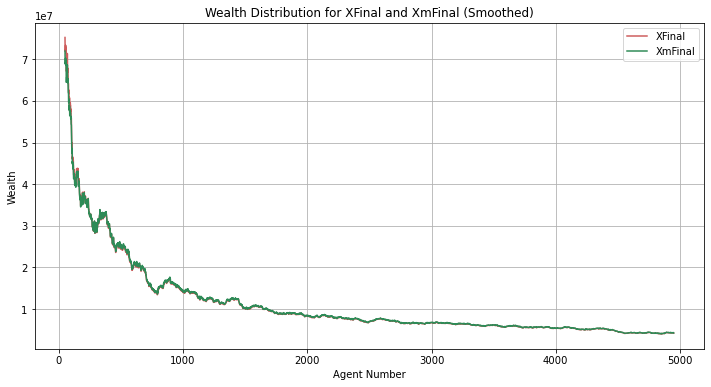

In [ ]:
# Plot X(final) and Xe(final)
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[S+1].flatten(), window_size), label='XFinal', linestyle='-', color="indianred")
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[S+1].flatten(), window_size), label='XmFinal', linestyle='-', color="seagreen")
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for XFinal and XmFinal (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

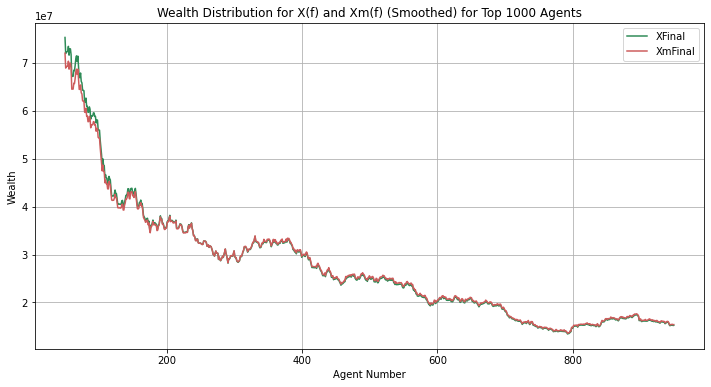

In [ ]:
# Ensure n is at least 1000 for slicing
#p = int(interact/100 * n)
p=1000
num_agents = min(n, p)

plt.figure(figsize=(12, 6))
plt.plot(
    moving_average(range(num_agents), window_size),
    moving_average(X_matrices[S+1].flatten()[:num_agents], window_size),
    label='XFinal',
    linestyle='-',
    color="seagreen"
)
plt.plot(
    moving_average(range(num_agents), window_size),
    moving_average(X_matrices_with_injection[S+1].flatten()[:num_agents], window_size),
    label='XmFinal',
    linestyle='-',
    color="indianred"
)
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title(f'Wealth Distribution for X(f) and Xm(f) (Smoothed) for Top {p} Agents')
plt.legend()
plt.grid(True)
plt.show()

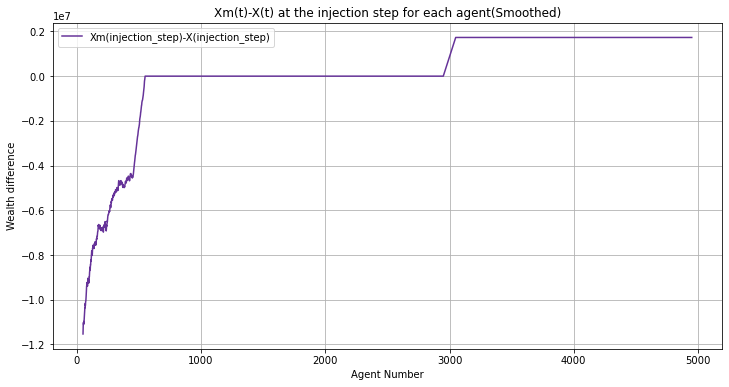

In [ ]:
# Plot X(injection_step) - Xe(injection_step)
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[injection_step].flatten()-X_matrices[injection_step].flatten(), window_size), label='Xm(injection_step)-X(injection_step)', linestyle='-', color="rebeccapurple")

plt.xlabel('Agent Number')
plt.ylabel('Wealth difference')
plt.title('Xm(t)-X(t) at the injection step for each agent(Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

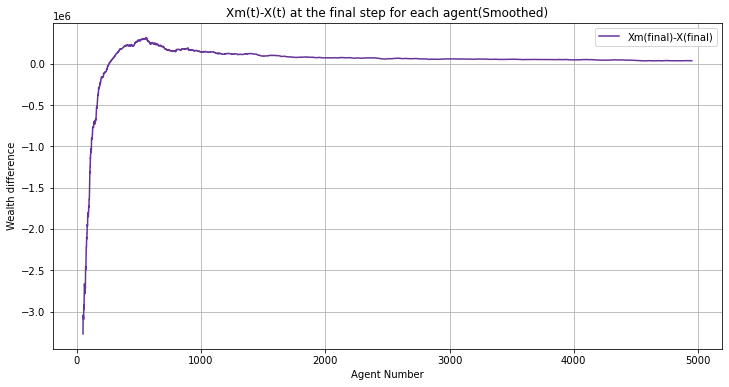

In [ ]:
# Plot X(S) - Xe(S)
plt.figure(figsize=(12, 6))
#plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[S-1].flatten(), window_size), label='X(Final)', linestyle='-')
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[12].flatten(), window_size), label='X(12)', linestyle='-')
#plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[12].flatten()-X_matrices[12].flatten(), window_size), label='Xe(12)-X(12)', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[S+1].flatten()-X_matrices[S+1].flatten(), window_size), label='Xm(final)-X(final)', linestyle='-', color="rebeccapurple")

plt.xlabel('Agent Number')
plt.ylabel('Wealth difference')
plt.title('Xm(t)-X(t) at the final step for each agent(Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

### TOP WEALTH RATIOS

In [ ]:
# Calculate the ratio of the wealth of the first % rows of Xe to the wealth of the first % rows of X for all time steps
# Extract the top % wealth for both scenarios from the merged DataFrame
df_results_merged = pd.merge(df_results_no_injection, df_results_with_injection, on='Step Number')
top_wealth_no_injection = df_results_merged[column_name_top_percent_noeps]
top_wealth_with_injection = df_results_merged[column_name_top_percent]

In [ ]:
# Calculate the ratio of top 10% wealth with injection to top 10% wealth without injection
wealth_ratios = top_wealth_with_injection / top_wealth_no_injection

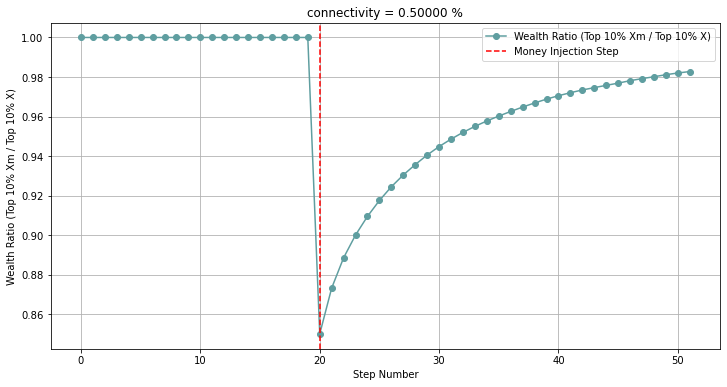

In [ ]:
# Plot the wealth ratios
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], wealth_ratios, marker='o', linestyle='-', color='cadetblue', label=f'Wealth Ratio (Top {top_percent}% Xm / Top {top_percent}% X)')
plt.axvline(injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Wealth Ratio (Top {top_percent}% Xm / Top {top_percent}% X)')
plt.title(f'connectivity = {interact:.5f} %')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the ratio of the wealth of the top wealth of the economy without injection w.r.t to one with monetary injection
wealth_ratios = {}
for step in range(S+2):
    wealth_ratios[step] = top_wealth_with_injection[step] / top_wealth_no_injection[step]

# Display the wealth_ratios
wealth_ratios_df = pd.DataFrame(wealth_ratios.items(), columns=['Step', 'Wealth Ratio of HNW Individuals with and without Injection'])
wealth_ratios_df = wealth_ratios_df.set_index('Step')  # Set 'Step' as the index
#wealth_ratios_df

### Bottom Wealth Ratios

In [ ]:
# Calculate the ratio of the wealth of the first % rows of Xe to the wealth of the first % rows of X for all time steps
# Extract the top % wealth for both scenarios from the merged DataFrame
bot_wealth_no_injection = df_results_merged[column_name_bottom_percent_noeps]
bot_wealth_with_injection = df_results_merged[column_name_bottom_percent]

In [ ]:
# Calculate the ratio of top 10% wealth with injection to top 10% wealth without injection
wealth_ratiosb = bot_wealth_with_injection / bot_wealth_no_injection

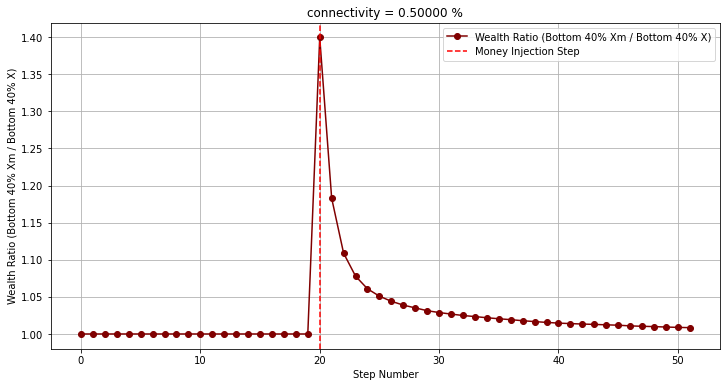

In [ ]:
# Plot the wealth ratios
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], wealth_ratiosb, marker='o', linestyle='-', color='maroon', label=f'Wealth Ratio (Bottom {bottom_percent}% Xm / Bottom {bottom_percent}% X)')
plt.axvline(injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Wealth Ratio (Bottom {bottom_percent}% Xm / Bottom {bottom_percent}% X)')
plt.title(f'connectivity = {interact:.5f} %')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the ratio of the wealth of the top wealth of the economy without injection w.r.t to one with monetary injection
wealth_ratiosb = {}
for step in range(S+2):
    wealth_ratiosb[step] = bot_wealth_with_injection[step] / bot_wealth_no_injection[step]

# Display the wealth_ratios
wealth_ratios_df2 = pd.DataFrame(wealth_ratiosb.items(), columns=['Step', 'Wealth Ratio of LNW Individuals with and without Injection'])
wealth_ratios_df2 = wealth_ratios_df2.set_index('Step')  # Set 'Step' as the index
#wealth_ratios_df2

### Total Wealth Ratio of Top to Bottom with distribution and without

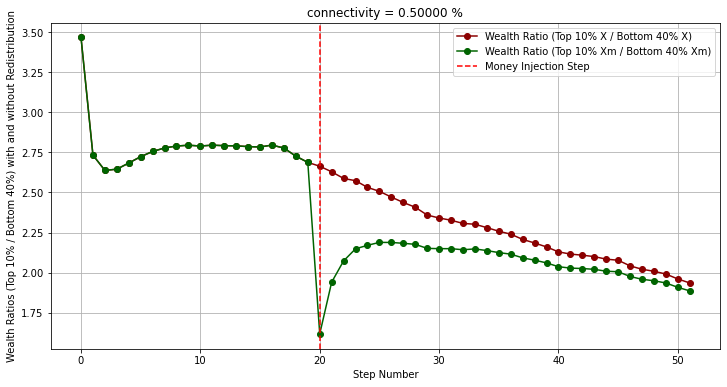

In [ ]:
top_wealth_no_injection = df_results_merged[column_name_top_percent_noeps]
top_wealth_with_injection = df_results_merged[column_name_top_percent]
bot_wealth_no_injection = df_results_merged[column_name_bottom_percent_noeps]
bot_wealth_with_injection = df_results_merged[column_name_bottom_percent]

wealthratio_noinjection = top_wealth_no_injection/bot_wealth_no_injection
wealthratio_withinjection = top_wealth_with_injection/bot_wealth_with_injection


plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], wealthratio_noinjection, marker='o', linestyle='-', color='darkred', label=f'Wealth Ratio (Top {top_percent}% X / Bottom {bottom_percent}% X)')
plt.plot(df_results_merged['Step Number'], wealthratio_withinjection, marker='o', linestyle='-', color='darkgreen', label=f'Wealth Ratio (Top {top_percent}% Xm / Bottom {bottom_percent}% Xm)')
plt.axvline(injection_step, color='r', linestyle='--', label='Money Injection Step')
plt.xlabel('Step Number')
plt.ylabel(f'Wealth Ratios (Top {top_percent}% / Bottom {bottom_percent}%) with and without Redistribution')
plt.title(f'connectivity = {interact:.5f} %')
plt.legend()
plt.grid(True)
plt.show()

### Total Wealth Check

#### Wealth Vectors without Redistribution

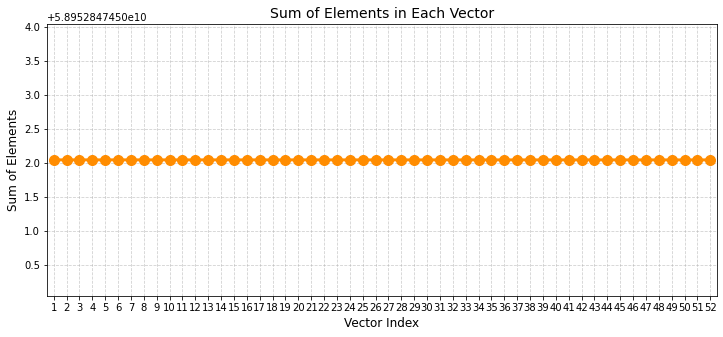

In [ ]:
# Sum the elements within each vector
vectors = X_matrices

# Sum the elements within each vector
vector_sums = [np.sum(vector) for vector in vectors]

# Stretching the plot
plt.figure(figsize=(12, 5))  # Wider figure

# Plotting the sums as a line graph
plt.plot(range(len(vector_sums)), vector_sums, marker='o', linestyle='-', color='darkorange', markersize=10, linewidth=3)

# Labeling
plt.xlabel('Vector Index', fontsize=12)
plt.ylabel('Sum of Elements', fontsize=12)
plt.title('Sum of Elements in Each Vector', fontsize=14)

# Customizing x-ticks
plt.xticks(range(len(vector_sums)), [f'{i+1}' for i in range(len(vectors))], fontsize=10)
plt.yticks(fontsize=10)

# Adjusting axis limits to stretch output
plt.xlim(-0.5, len(vectors) - 0.5)
plt.ylim(min(vector_sums) - 2, max(vector_sums) + 2)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


#### Wealth Vectors with Redistribution

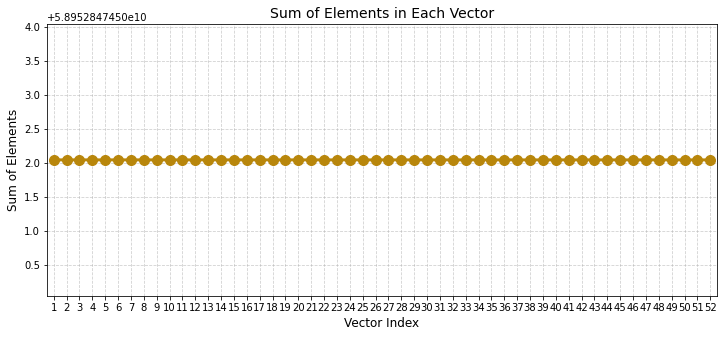

In [ ]:
# Sum the elements within each vector
vectors = X_matrices_with_injection

# Sum the elements within each vector
vector_sums = [np.sum(vector) for vector in vectors]

# Stretching the plot
plt.figure(figsize=(12, 5))  # Wider figure

# Plotting the sums as a line graph
plt.plot(range(len(vector_sums)), vector_sums, marker='o', linestyle='-', color='darkgoldenrod', markersize=10, linewidth=3)

# Labeling
plt.xlabel('Vector Index', fontsize=12)
plt.ylabel('Sum of Elements', fontsize=12)
plt.title('Sum of Elements in Each Vector', fontsize=14)

# Customizing x-ticks
plt.xticks(range(len(vector_sums)), [f'{i+1}' for i in range(len(vectors))], fontsize=10)
plt.yticks(fontsize=10)

# Adjusting axis limits to stretch output
plt.xlim(-0.5, len(vectors) - 0.5)
plt.ylim(min(vector_sums) - 2, max(vector_sums) + 2)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()
